In [28]:
import geopandas as gp
import pandas as pd
from collections import Counter
import os

# 2022 Alaska Precinct Boundaries and Election Results File



## Load in Files, Initial Processing

- Note: This file was created after the 2022 Alaska precinct-level election results file, that file is used as an input to this notebook
- [Precinct Boundary File Source](https://www.elections.alaska.gov/research/district-maps/)


In [29]:
# Load in precinct shapefile
ak_precs = gp.read_file("./raw-from-source/AK_Election_Precincts_2022Interim/Precincts.shp")

# Load in election results file
ak_results = pd.read_csv("./raw-from-source/ak_gen_22_prec.csv")

# Define a list of races
races = [i for i in list(ak_results.columns) if i not in ['UNIQUE_ID','PRECINCT','District']]

# Look that the precinct column appears to be unique
ak_results["PRECINCT"].value_counts(dropna = False)

01-600 Ketchikan No. 1         1
36-046 Copper Center           1
36-086 Holy Cross              1
36-082 Grayling                1
36-078 Glennallen              1
                              ..
16-470 West Anchorage No. 5    1
16-465 West Anchorage No. 4    1
16-460 West Anchorage No. 3    1
16-455 West Anchorage No. 2    1
40-040 Wainwright              1
Name: PRECINCT, Length: 401, dtype: int64

## Perform the Join


In [30]:
# Try out an initial join
test = gp.GeoDataFrame(pd.merge(ak_precs, ak_results, how = "outer", left_on = "Precinct_N", right_on = "PRECINCT", indicator = True))

# Based on the results of the above test, rename certain shapes in the precinct file
precs_rename_dict = {
    "05-865 Seward/Lowell Point":"05-865 Seward-Lowell Point",
    "06-250 Kachemak/Fritz Creek":"06-250 Kachemak-Fritz Creek",
    "06-280 Seldovia/Kachemak Bay":"06-280 Seldovia-Kachemak Bay",
    "02-755 Petersburg/Kupreanof":"02-755 Petersburg-Kupreanof",
    "02-750 Pelican/Elfin Cove":"02-750 Pelican-Elfin Cove",
    "36-114 Mcgrath":"36-114 McGrath",
    "26-375 Mat-su Campus":"26-375 Mat-Su Campus",
}

ak_precs["Precinct_N"] = ak_precs["Precinct_N"].map(precs_rename_dict).fillna(ak_precs["Precinct_N"])

# Try the join again
joined_pber = gp.GeoDataFrame(pd.merge(ak_precs, ak_results, how = "outer", left_on = "Precinct_N", right_on = "PRECINCT", indicator = True, validate="1:1"))

# Look at the results of the join
print(joined_pber["_merge"].value_counts())

# Drop the "_merge" column
joined_pber.drop("_merge", axis = 1, inplace = True)

both          401
left_only       0
right_only      0
Name: _merge, dtype: int64


## Examine Split Precincts

In [31]:
def is_split_precinct(district_assignment_list):
    c = Counter([x[0] for x in district_assignment_list])
    greater_than_one = {x:[y[1] for y in district_assignment_list if y[0]==x] for x, count in c.items() if count > 1}
    if len(greater_than_one)==0:
        return 0
    else:
        return greater_than_one
    
def get_level_dist(column_name):
    if column_name[0:4] == "GSLP":
        level = "SL"
        dist = "004"
    elif column_name[0:3] == "GSL":
        level = "SL"
        dist = column_name[3:5]
    elif column_name[0:3] == "GSU":
        level = "SU"
        dist = column_name[3:4]
    elif column_name[0:6] == "G22CON":
        level = "CON"
        dist = "AT-LARGE"
    else:
        print(column_name)
        raise ValueError
    return level,dist

def contains_sldl(dist_list):
    for dist_tuple in dist_list:
        if dist_tuple[0] == "SL":
            return dist_tuple[1]
        
def contains_cong(dist_list):
    for dist_tuple in dist_list:
        if dist_tuple[0] == "CON":
            return dist_tuple[1]
        
def contains_sldu(dist_list):
    for dist_tuple in dist_list:
        if dist_tuple[0] == "SU":
            return dist_tuple[1]

precinct_mapping_dict = {}
split_precincts_list = {}
for index,row in joined_pber.iterrows():
    precinct_list = []
    for contest in races:
        if(row[contest]!=0) and ("G22CON" in contest or "GSL" in contest or "GSU" in contest):
            precinct_info = get_level_dist(contest)
            if precinct_info not in precinct_list:
                precinct_list.append(get_level_dist(contest))
    is_split = is_split_precinct(precinct_list)
    if (is_split):
        split_precincts_list[row["UNIQUE_ID"]]=is_split
    precinct_mapping_dict[row["UNIQUE_ID"]]=precinct_list
    
cong_check_list = {i:contains_cong(precinct_mapping_dict[i]) for i in precinct_mapping_dict.keys()}
sldu_check_list = {i:contains_sldu(precinct_mapping_dict[i]) for i in precinct_mapping_dict.keys()}
sldl_check_list = {i:contains_sldl(precinct_mapping_dict[i]) for i in precinct_mapping_dict.keys()}

In [32]:
print(split_precincts_list)

{}


In [33]:
# Make SLDU and SLDL district assignments using the above
joined_pber["SLDU_DIST"] = joined_pber["UNIQUE_ID"].map(sldu_check_list)
joined_pber["SLDL_DIST"] = joined_pber["UNIQUE_ID"].map(sldl_check_list)

In [34]:
# The precinct shapefiles already contained district assignment fields, look into instances
# where that file does not match the assignment we provided based off election results
print(joined_pber[joined_pber["SLDU_DIST"]!=joined_pber["SenateDist"]].shape)

print(joined_pber[joined_pber["SLDL_DIST"]!=joined_pber["HouseDistr"]].shape)

(50, 267)
(0, 267)


Note: We will spatially check the assignments below to make sure they are correct, as there are discrepancies for the SLDU and Senate assignments.

## Clean up N/A District Assignments

There was no State Senate election in District T in Alaska in 2022, these values will be filled in 

In [35]:
def clean_na_dist_assignments(elections_gdf, district_gdf, unique_ID_col, elections_gdf_dist_ID, district_gdf_ID, ):
    
    if elections_gdf[elections_gdf[elections_gdf_dist_ID].isna()].shape[0]==0:
        print("No assignments to make")
        return elections_gdf
    
    original_crs = elections_gdf.crs
    elections_gdf = elections_gdf.to_crs(3857)
    
    district_gdf = district_gdf.to_crs(3857)
    
    dist_clean = gp.overlay(elections_gdf[elections_gdf[elections_gdf_dist_ID].isna()], district_gdf, how = "intersection")

    dist_clean['area'] = dist_clean.area

    na_assignment_dict = {}

    for val in dist_clean[unique_ID_col].unique():

        assignment = dist_clean.loc[dist_clean[unique_ID_col] == val].nlargest(1, 'area')[district_gdf_ID].values[0]
        na_assignment_dict[val] = assignment

    elections_gdf[elections_gdf_dist_ID] = elections_gdf[unique_ID_col].map(na_assignment_dict).fillna(elections_gdf[elections_gdf_dist_ID])    

    elections_gdf = elections_gdf.to_crs(original_crs)
    
    return elections_gdf

Note: SLDU and SLDL files can be found [here](https://redistrictingdatahub.org/wp-content/uploads/2023/03/readme_national_2022_elections_st_leg_boundaries.txt)


In [36]:
SLDU_PATH = "/Users/peterhorton/Documents/RDH/raw_data/state_leg/national_post_2021_redistricting_st_leg_boundaries/national_post_2021_redistricting_st_leg_upper_boundaries/national_post_2021_redistricting_st_leg_upper_boundaries.shp"
SLDL_PATH = "/Users/peterhorton/Documents/RDH/raw_data/state_leg/national_post_2021_redistricting_st_leg_boundaries/national_post_2021_redistricting_st_leg_lower_boundaries/national_post_2021_redistricting_st_leg_lower_boundaries.shp"

# Load in post-redistricting SLDU and SLDL shapefiles
ak_sldu_districts = gp.read_file(SLDU_PATH)
ak_sldl_districts = gp.read_file(SLDL_PATH)

ak_sldu_districts = ak_sldu_districts.to_crs(joined_pber.crs)
ak_sldl_districts = ak_sldl_districts.to_crs(joined_pber.crs)

ak_sldu_districts = ak_sldu_districts[ak_sldu_districts["STATE"]=="AK"]
ak_sldl_districts = ak_sldl_districts[ak_sldl_districts["STATE"]=="AK"]

In [37]:
joined_pber = clean_na_dist_assignments(joined_pber, ak_sldu_districts, "UNIQUE_ID", "SLDU_DIST", "DISTRICT")

/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/geopandas/geoseries.py:843: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for idx, s in self.geometry.iteritems():


## Check Geometries

In [38]:
from matplotlib.lines import Line2D

def compare_geometries(gdf_1,gdf_2,left_gdf_name,right_gdf_name,join_col_name,shape_name,area_threshold=.1):
    '''
    Function that joins to GeoDataFrames on a column and reports area differences row-by-row
    '''
    gdf_1 = gdf_1.to_crs(3857)
    gdf_2 = gdf_2.to_crs(3857)
    both = pd.merge(gdf_1,gdf_2,how="outer",on=join_col_name,validate="1:1",indicator=True)
    if(both["_merge"].str.contains("_")).any():
        print("Non-unique merge values")
        print(both[both["_merge"]!="both"])
        raise ValueError
    left_geoms = gp.GeoDataFrame(both,geometry="geometry_x")
    right_geoms = gp.GeoDataFrame(both,geometry="geometry_y")
    left_geoms["geometry_x"]=left_geoms.buffer(0)
    right_geoms["geometry_y"]=right_geoms.buffer(0)
#     if (left_geoms.is_valid==False).any():
#         raise ValueError
#     elif(right_geoms.is_valid==False).any():
#         raise ValueError
    count = 0
    area_list = []
    print("Checking " + str(both.shape[0])+" "+shape_name +" for differences of greater than "+str(area_threshold)+" km^2")
    print()
    for index,row in both.iterrows():
        diff = left_geoms.iloc[[index]].symmetric_difference(right_geoms.iloc[[index]])
        intersection = left_geoms.iloc[[index]].intersection(right_geoms.iloc[[index]])
        area = float(diff.area/10e6)
        area_list.append(area)
        if (area > area_threshold):
            count += 1
            name = left_geoms.at[index,join_col_name]
            print(str(count)+") For " + name + " difference in area is " + str(area))
            if (intersection.iloc[0].is_empty):
                base = left_geoms.iloc[[index]].plot(color="orange",figsize=(10,10))
                right_geoms.iloc[[index]].plot(color="blue",ax=base)
                base.set_title(name)
                custom_lines = [Line2D([0], [0], color='green', lw=4),
                Line2D([0], [0], color='orange', lw=4),
                Line2D([0], [0], color='blue', lw=4)]
                base.legend(custom_lines, ['Overlap', left_gdf_name,right_gdf_name])
            else:
                base = left_geoms.iloc[[index]].plot(color="orange",figsize=(10,10))
                right_geoms.iloc[[index]].plot(color="blue",ax=base)
                intersection.plot(color="green",ax=base)
                base.set_title(name)
                custom_lines = [Line2D([0], [0], color='green', lw=4),
                Line2D([0], [0], color='orange', lw=4),
                Line2D([0], [0], color='blue', lw=4)]
                base.legend(custom_lines, ['Overlap', left_gdf_name,right_gdf_name])
                
                
    df = pd.DataFrame(area_list)
    print()
    print("Scroll down to see plots of any differences")
    print()
    print("Of the "+ str(both.shape[0])+" "+ shape_name+ ":")
    print()
    print(str(len(df[df[0]==0]))+" "+shape_name+"  w/ a difference of 0 km^2")
    print(str(len(df[(df[0]<.1) & (df[0]>0)]))+ " "+shape_name+"  w/ a difference between 0 and .1 km^2")
    print(str(len(df[(df[0]<.5) & (df[0]>=.1)]))+ " "+shape_name+"  w/ a difference between .1 and .5 km^2")
    print(str(len(df[(df[0]<1) & (df[0]>=.5)]))+ " "+shape_name+"  w/ a difference between .5 and 1 km^2")
    print(str(len(df[(df[0]<2) & (df[0]>=1)]))+ " "+shape_name+"  w/ a difference between 1 and 2 km^2")
    print(str(len(df[(df[0]<5) & (df[0]>=2)]))+ " "+shape_name+"  w/ a difference between 2 and 5 km^2")
    print(str(len(df[(df[0]>=5)]))+ " "+shape_name+"  w/ a difference greater than 5 km^2")

Checking 20 districts for differences of greater than 1 km^2

1) For Q difference in area is 6.335100886338298
2) For R difference in area is 6.293281505575445

Scroll down to see plots of any differences

Of the 20 districts:

0 districts  w/ a difference of 0 km^2
13 districts  w/ a difference between 0 and .1 km^2
4 districts  w/ a difference between .1 and .5 km^2
1 districts  w/ a difference between .5 and 1 km^2
0 districts  w/ a difference between 1 and 2 km^2
0 districts  w/ a difference between 2 and 5 km^2
2 districts  w/ a difference greater than 5 km^2
Checking 40 districts for differences of greater than 1 km^2

1) For 34 difference in area is 6.333849220829586
2) For 35 difference in area is 2.7847378386774997
3) For 36 difference in area is 9.013537663161525
4) For 37 difference in area is 2.621557027251543
5) For 38 difference in area is 1.8811689743368278

Scroll down to see plots of any differences

Of the 40 districts:

0 districts  w/ a difference of 0 km^2
29 distr

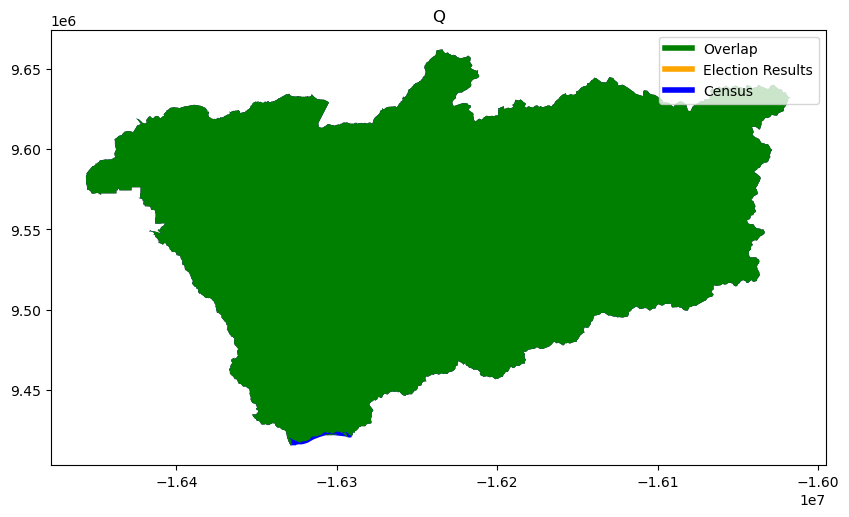

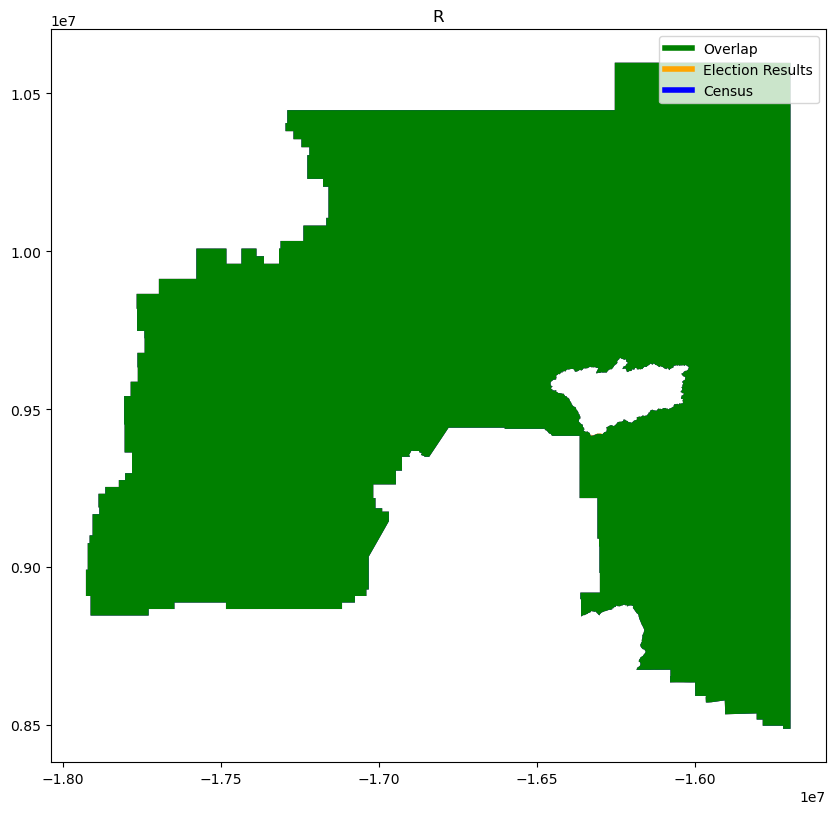

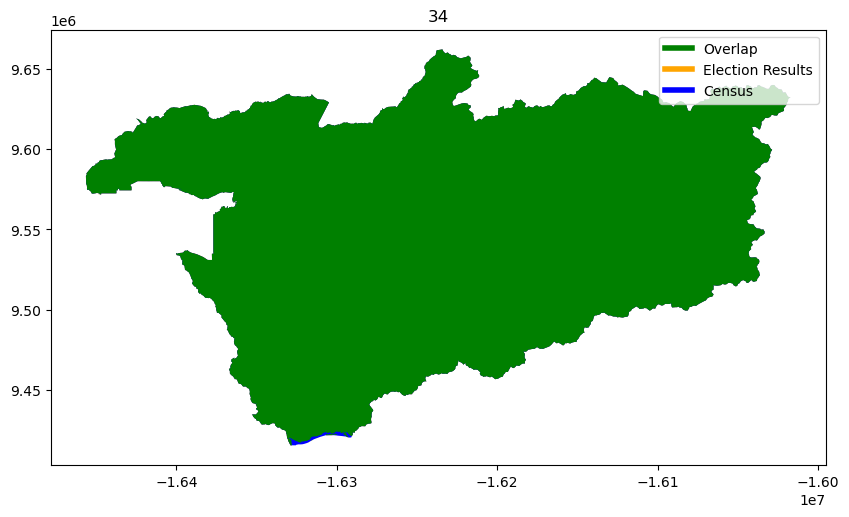

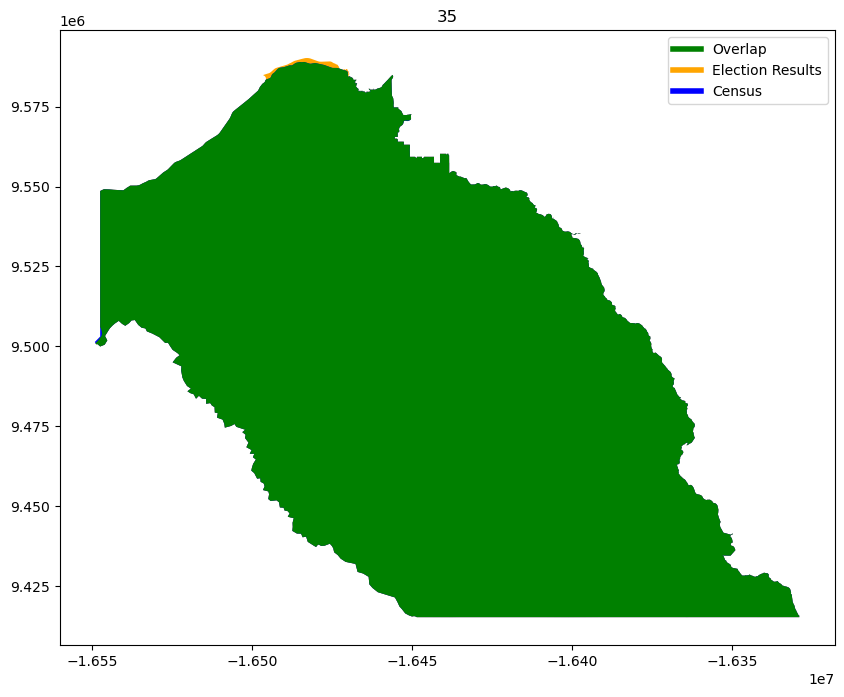

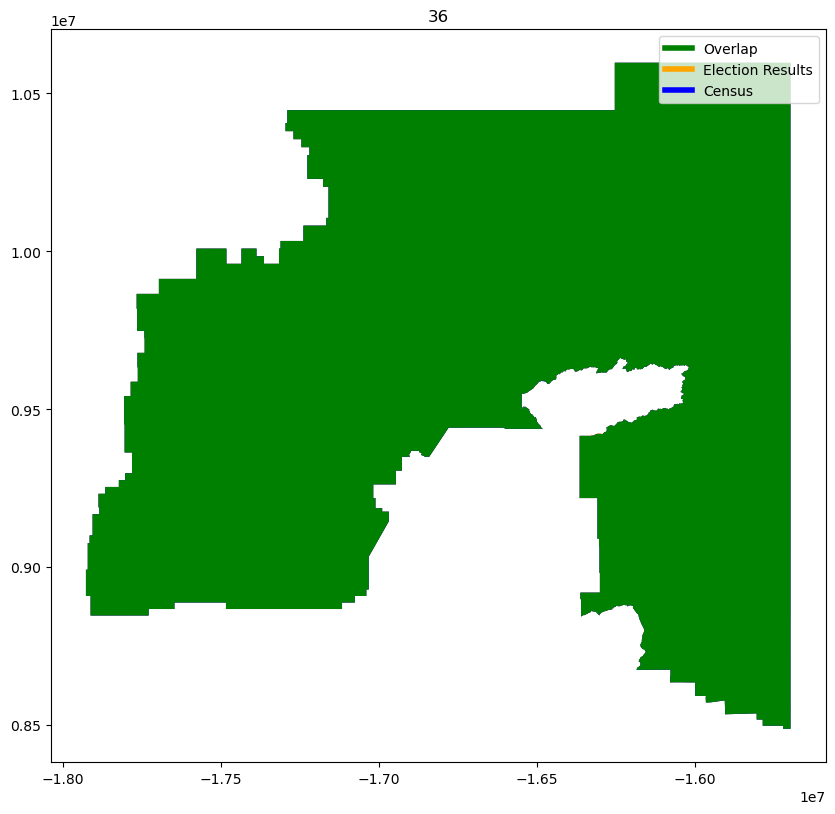

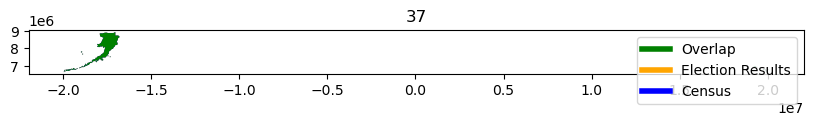

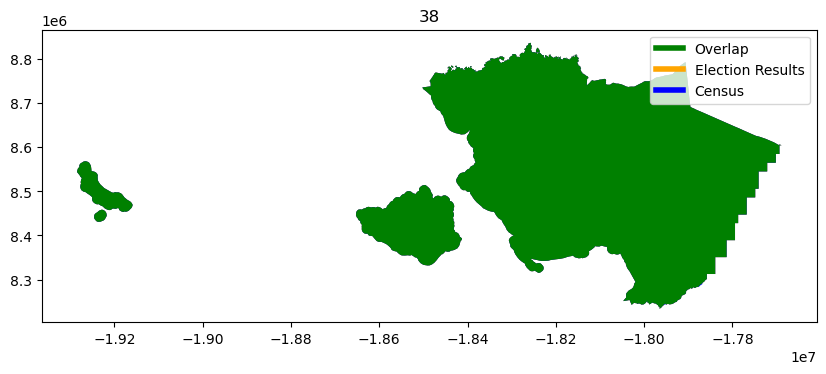

In [39]:
ak_sldl_districts.rename(columns = {"DISTRICT":"SLDL_DIST"}, inplace = True)
ak_sldu_districts.rename(columns = {"DISTRICT":"SLDU_DIST"}, inplace = True)

filtered_sldl_results = joined_pber[~joined_pber["SLDL_DIST"].isna()].dissolve("SLDL_DIST")
filtered_sldl_results.reset_index(inplace = True, drop = False)

filtered_sldu_results = joined_pber[~joined_pber["SLDU_DIST"].isna()].dissolve("SLDU_DIST")
filtered_sldu_results.reset_index(inplace = True, drop = False)

ak_sldl_districts["SLDL_DIST"] = ak_sldl_districts["SLDL_DIST"].astype(str).str.zfill(2)

compare_geometries(filtered_sldu_results, ak_sldu_districts ,"Election Results", "Census", "SLDU_DIST","districts",area_threshold=1)
compare_geometries(filtered_sldl_results, ak_sldl_districts ,"Election Results", "Census", "SLDL_DIST","districts",area_threshold=1)


# Final File Exporting

In [40]:
joined_pber[joined_pber["SLDL_DIST"]!=joined_pber["District"].astype(str).str.zfill(2)]
joined_pber.drop("District", axis = 1, inplace = True)

In [41]:
if not os.path.exists("./ak_gen_2022_prec/ak_gen_2022_prec"):
    if not os.path.exists("./ak_gen_2022_prec"):
        os.mkdir("./ak_gen_2022_prec")
    os.mkdir("./ak_gen_2022_prec/ak_gen_2022_prec")
    
for col in races:
    joined_pber[col] = joined_pber[col].astype(int)
    
joined_pber = gp.GeoDataFrame(joined_pber[["UNIQUE_ID","PRECINCT","SLDL_DIST","SLDU_DIST"]+races+["geometry"]])

In [31]:
joined_pber.to_file("./ak_gen_2022_prec/ak_gen_2022_prec/ak_gen_2022_prec.shp")

/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/geopandas/io/file.py:299: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


## Random Code Used for README

In [27]:
{"UNIQUE_ID":"Unique precinct identifier (for consistency across our files)",   
"PRECINCT":"County precinct identifier", 
"District":"Alaska state house district", 
"G22BMQNO":"Ballot Measure question no response", 
"G22BMQYES":"Ballot Measure question yes response", 
"G22CONDPEL":"Peltola, Mary S. - DEM",
"G22CONLBYE":"Bye, Chris - LIB",
"G22CONOWRI":"Write-in", 
"G22CONRBEG":"Begich, Nick - REP", 
"G22CONRPAL":"Palin, Sarah - REP",
"G22GOVDGAR":"Gara/Cook - DEM",
"G22GOVNWAL":"Walker/Drygas - NON",
"G22GOVOWRI":"Write-in",
"G22GOVRDUN":"Dunleavy/Dahlstrom - REP",
"G22GOVRPIE":"Pierce/Grunwald - REP",
"G22SACNHAR":"Harbison for SAC no vote",
"G22SACYHAR":"Harbison for SAC yes vote",
"G22USSDCHE":"Chesbro, Patricia R. - DEM",
"G22USSOWRI":"Write-in",
"G22USSRKEL":"Kelley, Buzz A. - REP",
"G22USSRMUR":"Murkowski, Lisa - REP",
"G22USSRTSH":"Tshibaka, Kelly C. - REP",
"GSL01NORT":'Ortiz, Daniel H. "Dan" - NON',
"GSL01OWRI":"Write-in",
"GSL01RBYN":"Bynum, Jeremy T. - REP",
"GSL02NHIM":"Himschoot, Rebecca - NON",
"GSL02OWRI":"Write-in",
"GSL02RSKA":"Skaflestad, Kenny - REP",
"GSL03DSTO":'Story, Andrea "Andi" - DEM',
"GSL03OWRI":"Write-in",
"GSL04DHAN":"Hannan, Sara - DEM",
"GSL04OWRI":"Write-in",
"GSL04UHAR":"Harmon, Darrell J. - UND",
"GSL05OWRI":"Write-in",
"GSL05RSTU":"Stutes, Louise B. - REP",
"GSL05RVIN":"Vincent, Benjamin T. - REP",
"GSL06NBRY":"Bryant, Ginger - NON",
"GSL06NFLO":'Flora, Louis A. "Louie" - NON',
"GSL06OWRI":"Write-in",
"GSL06RVAN":"Vance, Sarah L. - REP",
"GSL07OWRI":"Write-in",
"GSL07RGIL":'Gillham, Ronald D. "Ron" - REP',
"GSL07RRUF":"Ruffridge, Justin - REP",
"GSL08OWRI":"Write-in",
"GSL08RCAR":"Carpenter, Ben - REP",
"GSL09DSCH":"Schaff, David L. - DEM",
"GSL09OWRI":"Write-in",
"GSL09RSHA":"Shaw, Laddie H. - REP",
"GSL10DSTO":"Storm, Caroline - DEM",
"GSL10LINS":"Insalaco, Mikel E. - LIB",
"GSL10OWRI":"Write-in",
"GSL10RJOH":"Johnson, Craig W. - REP",
"GSL11NFEA":"Featherly, Walter T. - NON",
"GSL11OWRI":"Write-in",
"GSL11RBIE":"Bieling, Ross P. - REP",
"GSL11RCOU":"Coulombe, Julie - REP",
"GSL12NSCH":"Schrage, Calvin R. - NON",
"GSL12OWRI":"Write-in",
"GSL12RMCD":"McDonald, Jay - REP",
"GSL13DJOS":"Josephson, Andy - DEM",
"GSL13OWRI":"Write-in",
"GSL13RHEN":'Henslee, Katherine J. "Kathy" - REP',
"GSL14NGAL":"Galvin, Alyse S. - NON",
"GSL14OWRI":"Write-in",
"GSL14RDAN":"Danger, Nicholas - REP",
"GSL15DWEL":"Wells, Denny - DEM",
"GSL15OWRI":"Write-in",
"GSL15REIB":"Eibeck, David - REP",
"GSL15RMCK":'McKay, Thomas W. "Tom" - REP',
"GSL16DARM":'Armstrong, Jennifer "Jennie" - DEM',
"GSL16OWRI":"Write-in",
"GSL16RVAZ":"Vazquez, Liz - REP",
"GSL17DDRU":"Drummond, Harriet A. - DEM",
"GSL17DFIE":'Fields, William Z. "Zack" - DEM',
"GSL17OWRI":"Write-in",
"GSL18DFRA":"Franks, Lyn D. - DEM",
"GSL18DGRO":"Groh, Cliff - DEM",
"GSL18OWRI":"Write-in",
"GSL18RNEL":"Nelson, David - REP",
"GSL19DMIN":"Mina, Genevieve G. - DEM",
"GSL19DWYA":"Wyatt, Russell O. - DEM",
"GSL19OWRI":"Write-in",
"GSL20DGRA":"Gray, Andrew T. - DEM",
"GSL20LKOH":"Kohlhaas, Scott A. - LIB",
"GSL20OWRI":"Write-in",
"GSL20RBAU":"Bauer, Paul A. - REP",
"GSL20RHAR":"Harary, Jordan I. - REP",
"GSL21DMEA":"Mears, Donna C. - DEM",
"GSL21OWRI":"Write-in",
"GSL21RWOL":"Wolfe, Forrest M. - REP",
"GSL22DEIS":"Eischeid, Ted J. - DEM",
"GSL22OWRI":"Write-in",
"GSL22RWRI":"Wright, Stanley A. - REP",
"GSL23OWRI":"Write-in",
"GSL23RALL":"Allard, Jamie - REP",
"GSL23RBRA":"Branson, Roger L. - REP",
"GSL24DNEL":"Nelson, Daryl W. - DEM",
"GSL24OWRI":"Write-in",
"GSL24RJAC":"Jackson, Sharon - REP",
"GSL24RSAD":"Saddler, Dan - REP",
"GSL25OWRI":"Write-in",
"GSL25RJOH":"Johnson, DeLena M. - REP",
"GSL25RWOO":"Wood, Lawrence D. - REP",
"GSL26LSTO":"Stokes, Daniel L. - LIB",
"GSL26OWRI":"Write-in",
"GSL26RTIL":"Tilton, Cathy L. - REP",
"GSL27OWRI":"Write-in",
"GSL27RCAR":"Carpenter, Brendan R. - REP",
"GSL27REAS":"Eastman, David - REP",
"GSL27RGRA":'Graham, Stuart R. "Stu" - REP',
"GSL28OWRI":"Write-in",
"GSL28RALL":"Allen, Rachel M. - REP",
"GSL28RMEN":"Menard, Steve - REP",
"GSL28RSUM":"Sumner, Jesse M. - REP",
"GSL28RWRI":"Wright, Jessica - REP",
"GSL29NHAA":"Haase, Elijah D. - NON",
"GSL29OWRI":"Write-in",
"GSL29RRAU":"Rauscher, George - REP",
"GSL30DMIN":"Mindiola, L. Joy - DEM",
"GSL30OWRI":"Write-in",
"GSL30RHOL":"Holmes, Doyle E. - REP",
"GSL30RMCC":"McCabe, Kevin J. - REP",
"GSL31DDIB":"Dibert, Maxine L. - DEM",
"GSL31OWRI":"Write-in",
"GSL31RLEB":"LeBon, Barton S. - REP",
"GSL31RNAS":"Nash, Kelly - REP",
"GSL32DLAW":"Lawrence, Van - DEM",
"GSL32OWRI":"Write-in",
"GSL32RGIV":"Givens, Timothy W. - REP",
"GSL32RSTA":"Stapp, Will B. - REP",
"GSL33OWRI":"Write-in",
"GSL33RPRA":'Prax, Glenn M. "Mike" - REP',
"GSL34DHOP":"Hopkins, Grier H. - DEM",
"GSL34OWRI":"Write-in",
"GSL34RDEM":"DeMars, Nate - REP",
"GSL34RTOM":"Tomaszewski, Frank J. - REP",
"GSL35CBRO":"Brown, Kieran C. - CON",
"GSL35DCAR":"Carrick, Ashley E. - DEM",
"GSL35OWRI":"Write-in",
"GSL35RMCK":"McKinley, Kevin - REP",
"GSL35RMCN":"McNeill, Ruben A. Jr. - REP",
"GSL36DFOW":'Fowler, Angela K. "Fitch" - DEM',
"GSL36OWRI":"Write-in",
"GSL36RCRO":"Cronk, Mike - REP",
"GSL37OWRI":"Write-in",
"GSL37UEDG":"Edgmon, Bryce - UND",
"GSL38DMCC":'McCormick, Conrad J. "C.J." - DEM',
"GSL38OWRI":"Write-in",
"GSL39AIVA":"Ivanoff, Tyler L. - AIP",
"GSL39DFOS":"Foster, Neal W. - DEM",
"GSL39OWRI":"Write-in",
"GSL40NPAT":'Patkotak, Josiah B. "Aullaqsruaq" - NON',
"GSL40OWRI":"Write-in",
"GSSC1NMEA":"Superior Court JD1 - Mead (Vote for 1) - NO",
"GSSC1NPAT":"Superior Court JD1 - Pate (Vote for 1) - NO",
"GSSC1NSCH":"Superior Court JD1 - Schally (Vote for 1) - NO",
"GSSC1YMEA":"Superior Court JD1 - Mead (Vote for 1) - YES",
"GSSC1YPAT":"Superior Court JD1 - Pate (Vote for 1) - YES",
"GSSC1YSCH":"Superior Court JD1 - Schally (Vote for 1) - YES",
"GSSC3NCAG":"Superior Court JD3 - Cagle (Vote for 1) - NO",
"GSSC3NEAS":"Superior Court JD3 - Easter (Vote for 1) - NO",
"GSSC3NGAN":"Superior Court JD3 - Gandbhir (Vote for 1) - NO",
"GSSC3NGAR":"Superior Court JD3 - Garton (Vote for 1) - NO",
"GSSC3NGIS":"Superior Court JD3 - Gist (Vote for 1) - NO",
"GSSC3NJOA":"Superior Court JD3 - Joanis (Vote for 1) - NO",
"GSSC3NKRI":"Superior Court JD3 - Kristiansen (Vote for 1) - NO",
"GSSC3NMAT":"Superior Court JD3 - Matthews (Vote for 1) - NO",
"GSSC3NPET":"Superior Court JD3 - Peterson (Vote for 1) - NO",
"GSSC3NRAM":"Superior Court JD3 - Ramgren (Vote for 1) - NO",
"GSSC3NSAX":"Superior Court JD3 - Saxby (Vote for 1) - NO",
"GSSC3NSTO":"Superior Court JD3 - Stohler (Vote for 1) - NO",
"GSSC3NWAL":"Superior Court JD3 - Wallace (Vote for 1) - NO",
"GSSC3YCAG":"Superior Court JD3 - Cagle (Vote for 1) - YES",
"GSSC3YEAS":"Superior Court JD3 - Easter (Vote for 1) - YES",
"GSSC3YGAN":"Superior Court JD3 - Gandbhir (Vote for 1) - YES",
"GSSC3YGAR":"Superior Court JD3 - Garton (Vote for 1) - YES",
"GSSC3YGIS":"Superior Court JD3 - Gist (Vote for 1) - YES",
"GSSC3YJOA":"Superior Court JD3 - Joanis (Vote for 1) - YES",
"GSSC3YKRI":"Superior Court JD3 - Kristiansen (Vote for 1) - YES",
"GSSC3YMAT":"Superior Court JD3 - Matthews (Vote for 1) - YES",
"GSSC3YPET":"Superior Court JD3 - Peterson (Vote for 1) - YES",
"GSSC3YRAM":"Superior Court JD3 - Ramgren (Vote for 1) - YES",
"GSSC3YSAX":"Superior Court JD3 - Saxby (Vote for 1) - YES",
"GSSC3YSTO":"Superior Court JD3 - Stohler (Vote for 1) - YES",
"GSSC3YWAL":"Superior Court JD3 - Wallace (Vote for 1) - YES",
"GSSC4NBEN":"Superior Court JD4 - Bennett (Vote for 1) - NO",
"GSSC4NHAA":"Superior Court JD4 - Haas (Vote for 1) - NO",
"GSSC4NPET":"Superior Court JD4 - Peterson (Vote for 1) - NO",
"GSSC4YBEN":"Superior Court JD4 - Bennett (Vote for 1) - YES",
"GSSC4YHAA":"Superior Court JD4 - Haas (Vote for 1) - YES",
"GSSC4YPET":"Superior Court JD4 - Peterson (Vote for 1) - YES",
"GSUAOWRI":"Write-in",
"GSUARSHE":"Sheldon, Mike - REP",
"GSUARSTE":"Stedman, Bert K. - REP",
"GSUBDKIE":"Kiehl, Jesse - DEM",
"GSUBOWRI":"Write-in",
"GSUCOWRI":"Write-in",
"GSUCRJON":"Jones, Walter H. - REP",
"GSUCRSMI":"Smith, Heath - REP",
"GSUCRSTE":"Stevens, Gary - REP",
"GSUDNCIZ":"Cizek, Andy - NON",
"GSUDOWRI":"Write-in",
"GSUDRBAB":"Babcock, Tuckerman - REP",
"GSUDRBJO":"Bjorkman, Jesse J. - REP",
"GSUEDCAC":"Cacy, Roselynn - DEM",
"GSUEOWRI":"Write-in",
"GSUERGIE":"Giessel, Cathy - REP",
"GSUERHOL":"Holland, Roger - REP",
"GSUFDPAR":"Park, Janice L. - DEM",
"GSUFOWRI":"Write-in",
"GSUFRKAU":"Kaufman, James D. - REP",
"GSUGDGRA":"Gray-Jackson, Elvi - DEM",
"GSUGOWRI":"Write-in",
"GSUGRSAN":"Sanders, Marcus D. - REP",
"GSUHDCLA":"Claman, Matt - DEM",
"GSUHOWRI":"Write-in",
"GSUHRCOS":"Costello, Mia - REP",
"GSUIDTOB":"Tobin, Loki G. - DEM",
"GSUIOWRI":"Write-in",
"GSUIUHER":"Herndon, Heather - UND",
"GSUJDDUN":"Dunbar, Forrest - DEM",
"GSUJDTAR":"Tarr, Geran - DEM",
"GSUJOWRI":"Write-in",
"GSUJRSAT":"Satterfield, Andrew E. - REP",
"GSUKDWIE":"Wielechowski, Bill - DEM",
"GSUKOWRI":"Write-in",
"GSUKRCUN":"Cunningham, John W. - REP",
"GSULOWRI":"Write-in",
"GSULRMCC":"McCarty, Ken - REP",
"GSULRMER":"Merrick, Kelly R. - REP",
"GSUMDCOO":"Cooper, Jim - DEM",
"GSUMOWRI":"Write-in",
"GSUMRHUG":"Hughes, Shelley - REP",
"GSUNOWRI":"Write-in",
"GSUNRCLA":"Clayton, Scott D. - REP",
"GSUNRWIL":"Wilson, David S. - REP",
"GSUNRWRI":"Wright, Stephen - REP",
"GSUOOWRI":"Write-in",
"GSUORMAS":"Massie, Doug A. - REP",
"GSUORSHO":"Shower, Michael K. - REP",
"GSUPDKAW":"Kawasaki, Scott - DEM",
"GSUPOWRI":"Write-in",
"GSUPRJAF":"Jafre, Alex N. - REP",
"GSUPRMAT":"Matherly, Jim - REP",
"GSUQASER":"Serkov, Arthur P. - AIP",
"GSUQNBEN":"Bennett, John D. - NON",
"GSUQOWRI":"Write-in",
"GSUQRMYE":"Myers, Robert H. Jr. - REP",
"GSURAWIL":'Williams, Robert "Bert" - AIP',
"GSUROWRI":"Write-in",
"GSURRBIS":"Bishop, Click - REP",
"GSURRVER":"Verhagen, Elijah M. - REP",
"GSUSDHOF":"Hoffman, Lyman F. - DEM",
"GSUSOWRI":"Write-in",
"GSUSVKEP":"Keppel, Willy - VET"}

{'UNIQUE_ID': 'Unique precinct identifier (for consistency across our files)',
 'PRECINCT': 'County precinct identifier',
 'District': 'Alaska state house district',
 'G22BMQNO': 'Ballot Measure question no response',
 'G22BMQYES': 'Ballot Measure question yes response',
 'G22CONDPEL': 'Peltola, Mary S. - DEM',
 'G22CONLBYE': 'Bye, Chris - LIB',
 'G22CONOWRI': 'Write-in',
 'G22CONRBEG': 'Begich, Nick - REP',
 'G22CONRPAL': 'Palin, Sarah - REP',
 'G22GOVDGAR': 'Gara/Cook - DEM',
 'G22GOVNWAL': 'Walker/Drygas - NON',
 'G22GOVOWRI': 'Write-in',
 'G22GOVRDUN': 'Dunleavy/Dahlstrom - REP',
 'G22GOVRPIE': 'Pierce/Grunwald - REP',
 'G22SACNHAR': 'Harbison for SAC no vote',
 'G22SACYHAR': 'Harbison for SAC yes vote',
 'G22USSDCHE': 'Chesbro, Patricia R. - DEM',
 'G22USSOWRI': 'Write-in',
 'G22USSRKEL': 'Kelley, Buzz A. - REP',
 'G22USSRMUR': 'Murkowski, Lisa - REP',
 'G22USSRTSH': 'Tshibaka, Kelly C. - REP',
 'GSL01NORT': 'Ortiz, Daniel H. "Dan" - NON',
 'GSL01OWRI': 'Write-in',
 'GSL01RBYN': '